In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [135]:
import os

# ─── USER PARAMETERS ───────────────────────────────────────────────────────────
total_size          = 2016
sliding_window_size = 10    # encoder length
validation_duration = 1000  # length of validation window
test_duration       = 2016  # length of test window
batch_size          = 32
max_epochs          = 7
base_folder         = "/content/drive/MyDrive/tft/"
model_save_folder   = base_folder + "models-o3"  # folder to save checkpoints
offset = 10000
# ────────────────────────────────────────────────────────────────────────────────

# ensure save directory exists
os.makedirs(model_save_folder, exist_ok=True)

In [136]:
# install required packages (only need to run once)
!pip install pytorch-lightning pytorch-forecasting

In [137]:
import math
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, Callback, ModelCheckpoint
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss

torch.set_float32_matmul_precision('medium')  # or 'high'

In [138]:
# load raw data
df = pd.read_csv(base_folder + "data/old/df_pca_n.csv").reset_index(drop=True)
df["time_idx"] = df.index
df["series"]   = "BTC"
pca_columns = [c for c in df.columns if c.startswith("pca")]

# build contiguous val and test from middle
train_df  = df.iloc[offset:offset + total_size].copy()
test_df = df.iloc[offset + total_size: offset + total_size + test_duration].copy()
valid_df = df.iloc[offset + total_size + test_duration: offset + total_size + test_duration + validation_duration].copy()

# helper to create dataset template
def create_dataset(df):
    return TimeSeriesDataSet(
        df,
        time_idx="time_idx",
        target="close",
        group_ids=["series"],
        min_encoder_length=sliding_window_size,
        max_encoder_length=sliding_window_size,
        min_prediction_length=1,
        max_prediction_length=1,
        static_categoricals=[],
        time_varying_known_reals=["time_idx"] + pca_columns,
        time_varying_unknown_reals=["close"],
        target_normalizer=GroupNormalizer(groups=["series"]),
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
        allow_missing_timesteps=True,
    )

In [139]:
# create dataset objects
train_dataset = create_dataset(train_df)
test_dataset  = TimeSeriesDataSet.from_dataset(
    train_dataset,
    test_df,
    predict=False,
    stop_randomization=True
)
valid_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    valid_df,
    predict=False,
    stop_randomization=True
)

# create dataloaders
train_dataloader = train_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=11)
test_dataloader  = test_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=11)
val_dataloader = valid_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=11)

In [140]:
# callback to record losses
class LossHistory(Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []
    def on_train_epoch_end(self, trainer, pl_module):
        self.train_losses.append(trainer.callback_metrics["train_loss"].item())
    def on_validation_epoch_end(self, trainer, pl_module):
        if not trainer.sanity_checking:
            self.val_losses.append(trainer.callback_metrics["val_loss"].item())

loss_history = LossHistory()

# checkpoint callback to save best model
checkpoint_callback = ModelCheckpoint(
    dirpath=model_save_folder,
    filename="best_tft",
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    save_last=True
)

In [141]:
# build TFT model
quantiles = [0.5]
tft = TemporalFusionTransformer.from_dataset(
    train_dataset,
    learning_rate=0.001,
    hidden_size=16,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=len(quantiles),
    loss=QuantileLoss(quantiles=quantiles),
)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [142]:
# trainer
trainer = Trainer(
    max_epochs=max_epochs,
    gradient_clip_val=0.01,
    # callbacks=[EarlyStopping(monitor="val_loss", patience=5), loss_history, checkpoint_callback],
    callbacks=[loss_history],
    enable_model_summary=False,
)

# train
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    # val_dataloaders=val_dataloader,
)

# optionally save final checkpoint
final_ckpt = os.path.join(model_save_folder, "final_tft.ckpt")
trainer.save_checkpoint(final_ckpt)
print(f"Best model: {checkpoint_callback.best_model_path}\nFinal model: {final_ckpt}")


INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Ski

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loops/training_epoch_loop.py:488: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
INFO: `Trainer.fit` stopped: `max_epochs=7` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=7` reached.


Best model: 
Final model: /content/drive/MyDrive/tft/models-o3/final_tft.ckpt


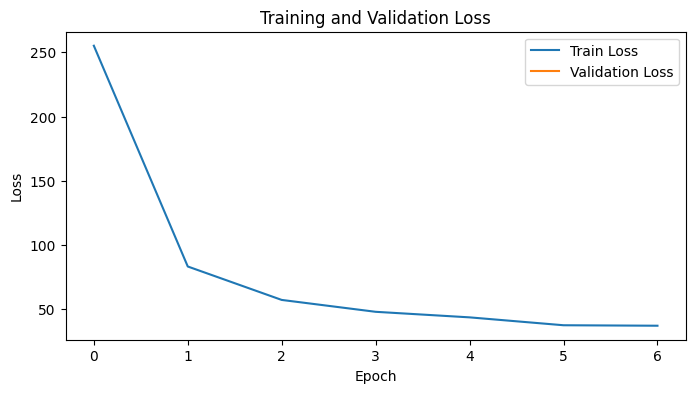

In [143]:
# plot losses
plt.figure(figsize=(8,4))
plt.plot(loss_history.train_losses, label="Train Loss")
plt.plot(loss_history.val_losses,   label="Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Training and Validation Loss"); plt.show()

In [144]:
# helper to get actuals & preds
def get_actuals_and_preds(dataloader):
    preds = tft.predict(dataloader).cpu().numpy().flatten()
    actuals = np.concatenate([y[0].numpy().flatten() for x,y in iter(dataloader)])
    return actuals, preds

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-

Train MSE: 1321.2334, MAE: 26.1630


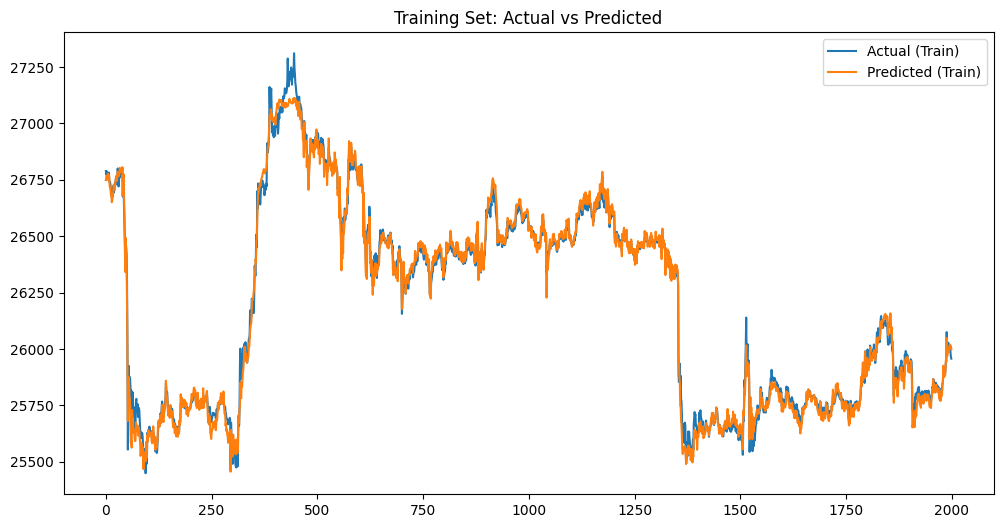

In [145]:
# evaluate & plot train
train_pred_dataloader = train_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
train_actual, train_pred = get_actuals_and_preds(train_pred_dataloader)
print(f"Train MSE: {np.mean((train_pred-train_actual)**2):.4f}, MAE: {np.mean(np.abs(train_pred-train_actual)):.4f}")
plt.figure(figsize=(12,6))
plt.plot(train_actual[:2000],label="Actual (Train)")
plt.plot(train_pred[:2000],  label="Predicted (Train)")
plt.title("Training Set: Actual vs Predicted"); plt.legend(); plt.show()


INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Test MSE: 57608.0234, MAE: 138.2741
RMSE: 240.0167


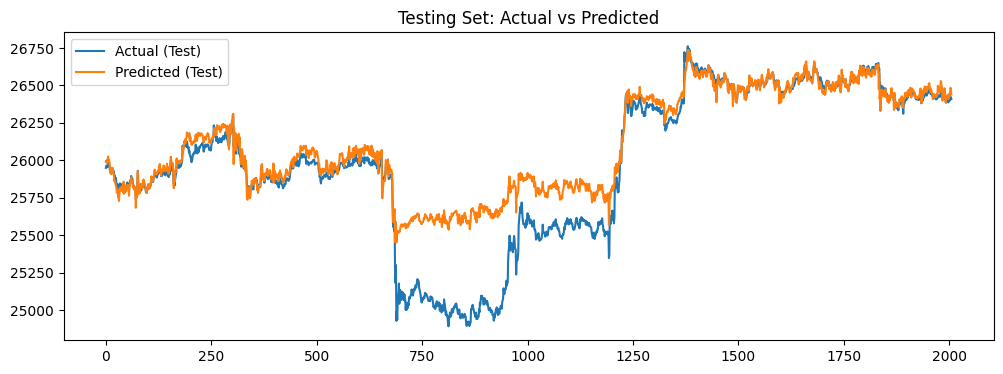

In [146]:
# evaluate & plot test
test_actual, test_pred = get_actuals_and_preds(test_dataloader)
mse_test = np.mean((test_pred-test_actual)**2)
print(f"Test MSE: {mse_test:.4f}, MAE: {np.mean(np.abs(test_pred-test_actual)):.4f}")
print(f"RMSE: {math.sqrt(mse_test):.4f}")
plt.figure(figsize=(12,4))
plt.plot(test_actual[:2016], label="Actual (Test)")
plt.plot(test_pred[:2016],   label="Predicted (Test)")
plt.title("Testing Set: Actual vs Predicted"); plt.legend(); plt.show()